# NFL Capstone EDA

I will be using SQL to create dataframes of the various tables and combinations to perform EDA

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import os
import sys

## Connect to Database and create dataframes of each table to combine later

In [2]:
conn = sqlite3.connect('NFLstats.db')

In [3]:
teamyearsummarySQL_Query = pd.read_sql_query("SELECT * FROM 'teamyearsummary'", conn)
teamyearsummary = pd.DataFrame(teamyearsummarySQL_Query)
del teamyearsummary['id']

In [4]:
weeksSQL_Query = pd.read_sql_query("SELECT * FROM 'weeks'", conn)
weeks = pd.DataFrame(weeksSQL_Query)
del weeks['id']

In [5]:
draftSQL_Query = pd.read_sql_query("SELECT * FROM 'draft'", conn)
draft = pd.DataFrame(draftSQL_Query)
#drop drafted special teams players only 78/4595 drafted players with 3 positions
draft = draft[draft.DraftPosition != 'ST']
del draft['id']

In [6]:
startersSQL_Query = pd.read_sql_query("SELECT * FROM 'starters'", conn)
starters = pd.DataFrame(startersSQL_Query)
#Removal of whitespace in 'Starting Player'
starters['StartingPlayer'] = starters['StartingPlayer'].str.strip()
del starters['id']

In [7]:
starters.head()

Team  Year  StartingPlayer  StartingPlayerAge  \
0  Arizona Cardinals  2002    Jake Plummer               1974   
1  Arizona Cardinals  2002    Thomas Jones               1978   
2  Arizona Cardinals  2002  Jason McAddley               1979   
3  Arizona Cardinals  2002   Frank Sanders               1973   
4  Arizona Cardinals  2002      Steve Bush               1974   

  StartingPosition  StartingPlayerYrs  StartingPlayerGS  
0               QB                  5                16  
1               RB                  2                 9  
2               WR                  0                 8  
3               WR                  7                12  
4               TE                  5                12

## Additional features added to starters df

In [8]:
#Create column of the number of years as a starter for that team
# This cell designates the players first year
# Have to filter by player and age because when scraping data, I had to go piece-wise, and did not generate unique playerid
starters['YrsTeamStarter'] = int(0)

for player in starters['StartingPlayer'].unique():
    for age in set(starters[(starters['StartingPlayer']==player)]['StartingPlayerAge']):
        firstyear = starters[(starters['StartingPlayer']==player) & (starters['StartingPlayerAge']==age)]['Year'].idxmin()
        starters.loc[firstyear, 'YrsTeamStarter'] = int(1)

In [9]:
#Loop through player and year, if it is player's first year, add team to list of teams and add 1 to counter
# if not first year, but team is in list, add another year as a starter to the YrsTeamStarter column
# if not first year, but team is not in team list, this is a new team, and years as starter is back to 1
for player in starters['StartingPlayer'].unique():
    for age in set(starters[(starters['StartingPlayer']==player)]['StartingPlayerAge']):
        teamyear = []
        yrscount = 0
        for year in starters[(starters['StartingPlayer']==player) & (starters['StartingPlayerAge']==age)]['Year'].sort_values().unique():
            mask = starters[(starters['StartingPlayer']==player) & (starters['StartingPlayerAge']==age) &(starters['Year']==year)].index
            if starters.loc[mask, 'YrsTeamStarter'].iloc[-1] == 1:
                yrscount = 1
                teamyear.extend(starters.loc[mask,'Team'])
                #print(player, year, teamyear, starters.loc[mask, 'YrsTeamStarter'].iloc[-1], '1')
                continue
            elif starters.loc[mask,'Team'].iloc[-1] in teamyear:
                yrscount += 1
                starters.loc[mask, 'YrsTeamStarter'] = yrscount
                teamyear.extend(starters.loc[mask,'Team'])
                #print(player, year, teamyear, starters.loc[mask, 'YrsTeamStarter'].iloc[-1], '2')
                continue
            elif starters.loc[mask,'Team'].iloc[-1] not in teamyear:
                starters.at[mask, 'YrsTeamStarter'] = 1
                teamyear.extend(starters.loc[mask,'Team'])
                #print(player, year, teamyear, starters.loc[mask, 'YrsTeamStarter'].iloc[-1], '3')
                continue
            else:
                pass

## Import data from nfldata github repository and prepare to combine with scraped data

In [10]:
roster = pd.read_csv('https://raw.githubusercontent.com/leesharpe/nfldata/master/data/rosters.csv')
nfldatateam = pd.read_csv('https://raw.githubusercontent.com/leesharpe/nfldata/master/data/teams.csv')

In [11]:
#remove duplicates and account for team name changes of 4 teams
#ex original SD --> San Diego Chargers new SD --> Los Angeles Chargers 
#allows for merge with my scraped data
teamdf = nfldatateam[['team', 'full']].drop_duplicates()
teamdf.iloc[31, 1] = 'Washington Football Team'
teamdf.iloc[28, 1] = 'Los Angeles Rams'
teamdf.iloc[25, 1] = 'Los Angeles Chargers'
teamdf.iloc[22, 1] = 'Las Vegas Raiders'
teamdf.set_index('team')

full
team                          
ARI          Arizona Cardinals
ATL            Atlanta Falcons
BAL           Baltimore Ravens
BUF              Buffalo Bills
CAR          Carolina Panthers
CHI              Chicago Bears
CIN         Cincinnati Bengals
CLE           Cleveland Browns
DAL             Dallas Cowboys
DEN             Denver Broncos
DET              Detroit Lions
GB           Green Bay Packers
HOU             Houston Texans
IND         Indianapolis Colts
JAX       Jacksonville Jaguars
KC          Kansas City Chiefs
MIA             Miami Dolphins
MIN          Minnesota Vikings
NE        New England Patriots
NO          New Orleans Saints
NYG            New York Giants
NYJ              New York Jets
OAK          Las Vegas Raiders
PHI        Philadelphia Eagles
PIT        Pittsburgh Steelers
SD        Los Angeles Chargers
SEA           Seattle Seahawks
SF         San Francisco 49ers
STL           Los Angeles Rams
TB        Tampa Bay Buccaneers
TEN           Tennessee Titans
WAS   Washington Football Team
LA            Los Angeles Rams
LAC       Los Angeles Chargers
LV           Las Vegas Raiders
WAS   Washington Football Team

In [12]:
#merge teamdf to roster to allow for merge on full team name from scraped data
roster = pd.merge(left=roster, right=teamdf, how='left', on='team')
roster.rename(columns={'full': 'Team','season':'Year', 'full_name':'StartingPlayer', 'av':'AV'}, inplace=True)
#Remove Duplicates 
roster = roster[['Year', 'StartingPlayer', 'AV', 'Team']]
#remove instances where av is na
roster = roster[roster['AV'].notna()]
roster.drop_duplicates(inplace=True)

### Joining of Approximate Value per player per year to starters.  The AV's purpose is as defined, "The approximations are intended only to distinguish as quickly and reliably as possible between large contributions, very large contributions, gigantic contributions, medium-sized contributions, small, smaller, and negligible contributions." 

https://www.pro-football-reference.com/blog/index6b92.html?p=465

In [13]:
starters.head()

Team  Year  StartingPlayer  StartingPlayerAge  \
0  Arizona Cardinals  2002    Jake Plummer               1974   
1  Arizona Cardinals  2002    Thomas Jones               1978   
2  Arizona Cardinals  2002  Jason McAddley               1979   
3  Arizona Cardinals  2002   Frank Sanders               1973   
4  Arizona Cardinals  2002      Steve Bush               1974   

  StartingPosition  StartingPlayerYrs  StartingPlayerGS  YrsTeamStarter  
0               QB                  5                16               1  
1               RB                  2                 9               1  
2               WR                  0                 8               1  
3               WR                  7                12               1  
4               TE                  5                12               1

In [14]:
roster.head()

Year   StartingPlayer   AV               Team
0  2006     Matt Leinart  8.0  Arizona Cardinals
1  2006   Jonathan Lewis  0.0  Arizona Cardinals
2  2006  Chris Liwienski  4.0  Arizona Cardinals
3  2006   J.J. Arrington  2.0  Arizona Cardinals
4  2006      Deuce Lutui  5.0  Arizona Cardinals

In [15]:
starters = pd.merge(left=starters, right=roster, how='left', on=['StartingPlayer','Year', 'Team'])

In [16]:
starters

Team  Year   StartingPlayer  StartingPlayerAge  \
0      Arizona Cardinals  2002     Jake Plummer               1974   
1      Arizona Cardinals  2002     Thomas Jones               1978   
2      Arizona Cardinals  2002   Jason McAddley               1979   
3      Arizona Cardinals  2002    Frank Sanders               1973   
4      Arizona Cardinals  2002       Steve Bush               1974   
...                  ...   ...              ...                ...   
12649   Tennessee Titans  2018     Brian Orakpo               1986   
12650   Tennessee Titans  2018       Logan Ryan               1991   
12651   Tennessee Titans  2018  Adoree' Jackson               1995   
12652   Tennessee Titans  2018    Kenny Vaccaro               1991   
12653   Tennessee Titans  2018      Kevin Byard               1993   

      StartingPosition  StartingPlayerYrs  StartingPlayerGS  YrsTeamStarter  \
0                   QB                  5                16               1   
1                   RB                  2                 9               1   
2                   WR                  0                 8               1   
3                   WR                  7                12               1   
4                   TE                  5                12               1   
...                ...                ...               ...             ...   
12649               LB                  9                13               7   
12650               DB                  5                14               3   
12651               DB                  1                13               2   
12652               DB                  5                13               1   
12653               DB                  2                16               2   

        AV  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN  
...    ...  
12649  7.0  
12650  6.0  
12651  6.0  
12652  6.0  
12653  8.0  

[12654 rows x 9 columns]

## Statistics of each table

In [17]:
teamyearsummary.describe().T

count         mean         std     min       25%  \
Year                       576.0  2010.500000    5.192637  2002.0  2006.000   
Wins                       576.0     7.982639    3.076369     0.0     6.000   
Losses                     576.0     7.982639    3.075804     0.0     6.000   
MoV                        576.0    -0.002083    6.288559   -16.3    -4.700   
SoS                        576.0     0.001389    1.655210    -4.6    -1.100   
SRS                        576.0     0.000868    6.228220   -17.4    -4.500   
SRS_Off                    576.0    -0.000347    4.366421   -11.7    -3.200   
SRS_Def                    576.0    -0.001562    3.518510    -9.2    -2.325   
Team_PF                    576.0   352.782986   70.997733   168.0   300.750   
Team_Total_Yards           576.0  5389.659722  625.460414  3572.0  4976.750   
Team_Plays_Offense         576.0  1012.904514   46.880936   865.0   983.000   
Team_yds_per_play_offense  576.0     5.313715    0.510621     3.8     5.000   
Team_Turnovers             576.0    25.548611    6.867775     8.0    20.000   
Team_Fumbles               576.0    10.467014    3.668283     2.0     8.000   
Team_First_down            576.0   308.473958   37.347618   191.0   283.750   
Team_Pass_Comp             576.0   331.661458   48.894402   204.0   297.000   
Team_Pass_Att              576.0   541.116319   60.173477   358.0   500.750   
Team_Pass_Yds              576.0  3567.008681  620.334595  1898.0  3104.500   
Team_Pass_Td               576.0    23.133681    7.341450     7.0    18.000   
Team_Pass_Int              576.0    15.081597    4.916903     2.0    12.000   
Team_Pass_Net_Yds_Att      576.0     6.166146    0.791026     4.1     5.600   
Team_Pass_First_Down       576.0   184.022569   31.031785    96.0   161.000   
Team_Rush_Att              576.0   435.157986   51.381618   304.0   398.000   
Team_Rush_Yds              576.0  1822.651042  335.119553  1129.0  1592.500   
Team_Rush_Tds              576.0    13.043403    5.061692     2.0     9.000   
Team_Rush_Yds_Att          576.0     4.171354    0.439124     3.1     3.900   
Team_Rush_First_Down       576.0    97.097222   19.450832    53.0    83.000   
Team_Score_Percent         576.0    12.907812    3.319511     4.0    10.575   
Opp_PF                     576.0   352.782986   57.784606   196.0   313.000   
Opp_Total_Yards            576.0  5389.657986  518.319213  3795.0  5051.500   
Opp_Plays_Offense          576.0  1012.911458   43.829442   882.0   981.000   
Opp_yds_per_play_offense   576.0     5.319792    0.425848     3.9     5.000   
Opp_Turnovers              576.0    25.548611    6.516152     7.0    21.000   
Opp_Fumbles                576.0    10.467014    3.551209     2.0     8.000   
Opp_First_down             576.0   308.473958   29.117083   228.0   289.000   
Opp_Pass_Comp              576.0   331.661458   36.052787   239.0   306.000   
Opp_Pass_Att               576.0   541.121528   44.787450   409.0   511.000   
Opp_Pass_Yds               576.0  3567.015625  429.358233  2413.0  3260.500   
Opp_Pass_Td                576.0    23.133681    5.626136     6.0    19.000   
Opp_Pass_Int               576.0    15.081597    4.859623     2.0    12.000   
Opp_Pass_Net_Yds_Att       576.0     6.180903    0.612890     4.3     5.800   
Opp_Pass_First_Down        576.0   184.022569   21.571749   127.0   169.000   
Opp_Rush_Att               576.0   435.159722   45.680846   332.0   404.000   
Opp_Rush_Yds               576.0  1822.642361  298.102347   985.0  1610.500   
Opp_Rush_Tds               576.0    13.043403    4.565640     3.0    10.000   
Opp_Rush_Yds_Att           576.0     4.177257    0.420914     2.8     3.900   
Opp_Rush_First_Down        576.0    97.097222   17.490497    53.0    85.000   
Opp_Score_Percent          576.0    12.940972    3.197100     3.9    10.675   

                               50%       75%     max  
Year                       2010.50  2015.000  2019.0  
Wins                          8.00    10.000 

In [18]:
weeks.describe().T

count         mean        std     min     25%     50%  \
Year                  9612.0  2010.500000   5.188397  2002.0  2006.0  2010.5   
Week_Points_Scored    9612.0    22.099771  10.284595     0.0    14.0    21.0   
Week_Points_Allowed   9612.0    22.099771  10.284595     0.0    14.0    21.0   
Week_First_Downs      9612.0    19.313670   5.032361     3.0    16.0    19.0   
Week_Total_Off_Yards  9612.0   337.307532  85.470544    26.0   279.0   337.0   
Week_Pass_Yards       9612.0   223.501769  78.556118    -7.0   168.0   219.0   
Week_Rush_Yards       9612.0   113.805764  51.625187   -18.0    77.0   107.0   
Week_Off_Turnovers    9612.0     1.595922   1.342601     0.0     1.0     1.0   
Week_Def_First_Downs  9612.0    19.313670   5.032361     3.0    16.0    19.0   
Week_Def_Total_Yards  9612.0   337.319913  85.465070    26.0   279.0   337.0   
Week_Def_Pass_Yards   9612.0   223.514253  78.553388    -7.0   168.0   219.0   
Week_Def_Rush_Yards   9612.0   113.805660  51.625589   -18.0    77.0   107.0   
Week_Def_Turnovers    9612.0     1.595922   1.342601     0.0     1.0     1.0   

                         75%     max  
Year                  2015.0  2019.0  
Week_Points_Scored      29.0    62.0  
Week_Points_Allowed     29.0    62.0  
Week_First_Downs        23.0    40.0  
Week_Total_Off_Yards   395.0   653.0  
Week_Pass_Yards        275.0   522.0  
Week_Rush_Yards        144.0   378.0  
Week_Off_Turnovers       2.0     8.0  
Week_Def_First_Downs    23.0    40.0  
Week_Def_Total_Yards   395.0   653.0  
Week_Def_Pass_Yards    275.0   522.0  
Week_Def_Rush_Yards    144.0   378.0  
Week_Def_Turnovers       2.0     8.0

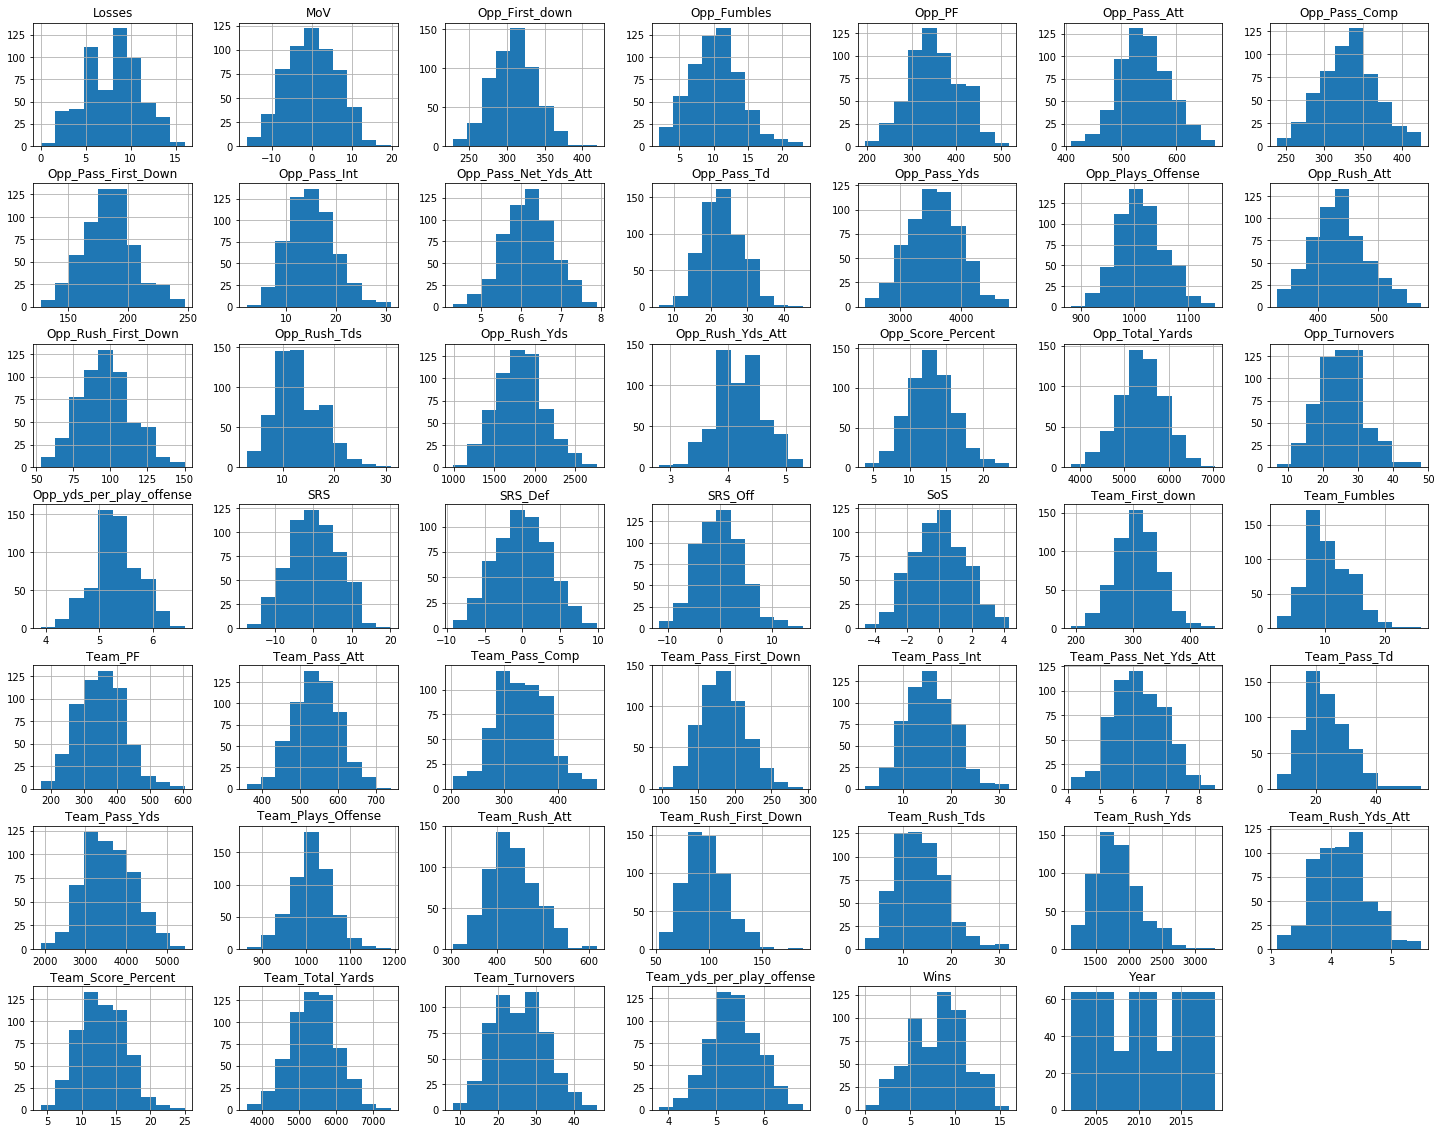

In [19]:
teamyearsummary.hist(bins=10, figsize=(25,20))
plt.show()

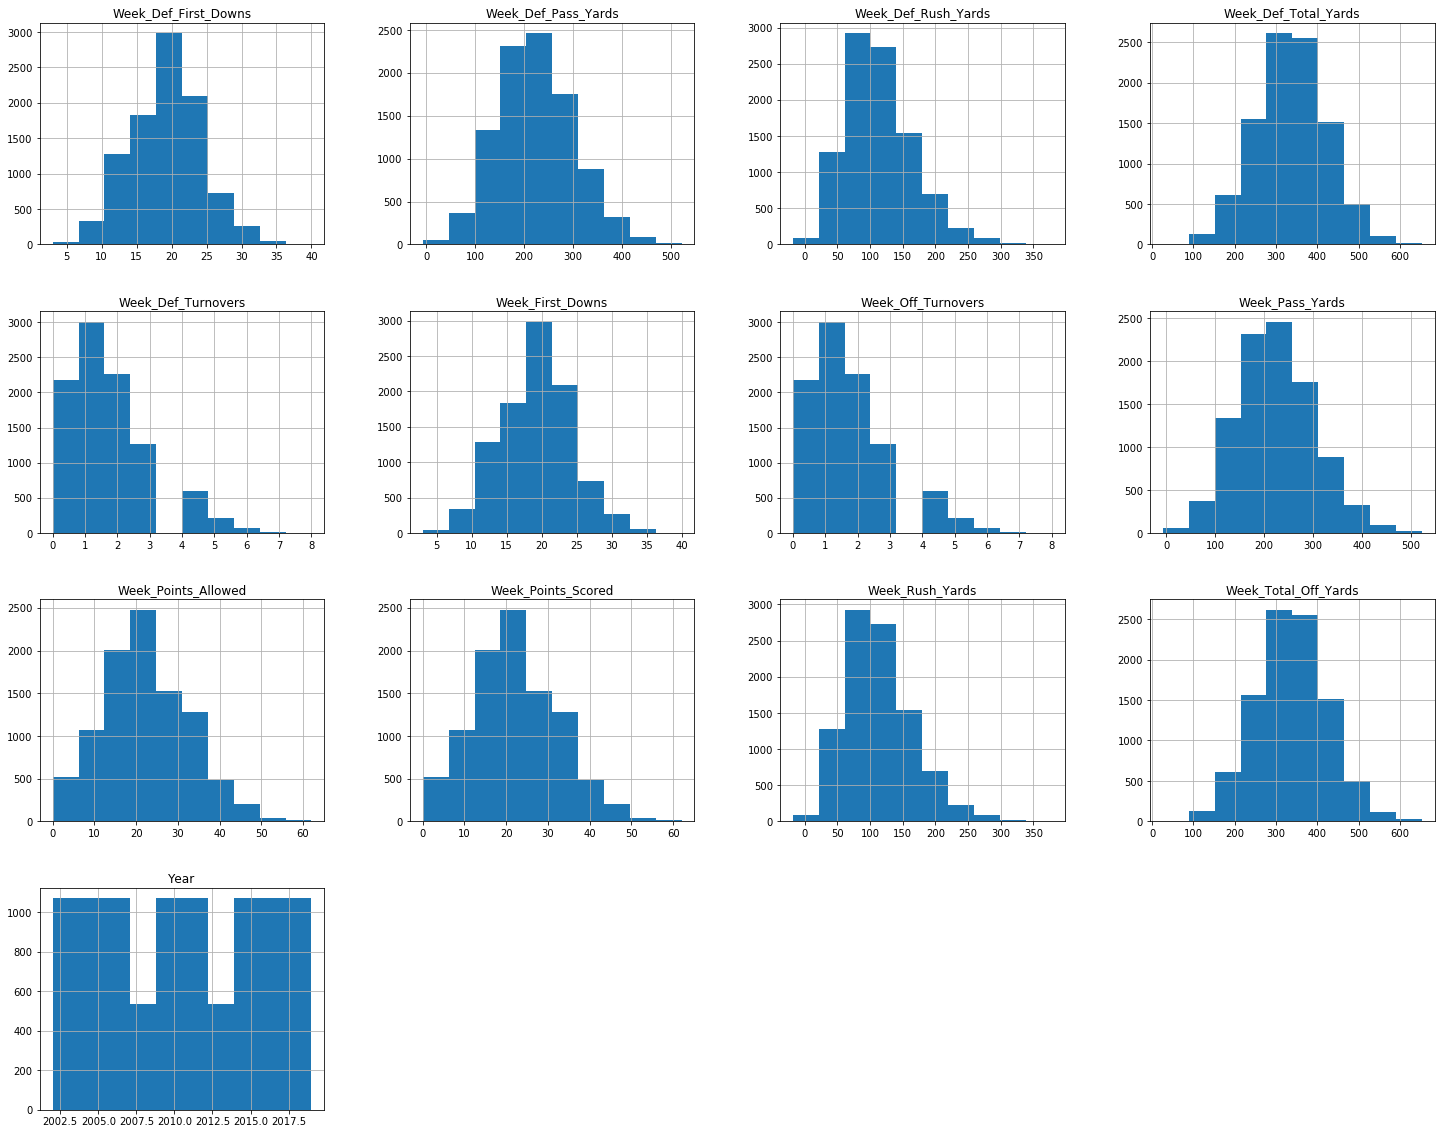

In [20]:
weeks.hist(bins=10, figsize=(25,20))
plt.show()

### What is more correlated with the play selection of pass vs. run on offense, the team, head coach, offensive coordinator or offensive scheme?

In [21]:
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat)+1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)
    for i in range(0,cat_num):
        cat_measures = measurements[np.argwhere(fcat == i).flatten()]
        n_array[i] = len(cat_measures)
        y_avg_array[i] = np.average(cat_measures)
    y_total_avg = np.sum(np.multiply(y_avg_array,n_array))/np.sum(n_array)
    numerator = np.sum(np.multiply(n_array,np.power(np.subtract(y_avg_array,y_total_avg),2)))
    denominator = np.sum(np.power(np.subtract(measurements,y_total_avg),2))
    if numerator == 0:
        eta = 0.0
    else:
        eta = np.sqrt(numerator/denominator)
    return eta

In [22]:
coachcategories = teamyearsummary['coach']

In [23]:
measurements = teamyearsummary['Team_Pass_Att'] / teamyearsummary['Team_Rush_Att']

In [24]:
correlation_ratio(coachcategories, measurements)

0.65932525552503829

In [25]:
offcoorcategories = teamyearsummary['offcoor']

In [26]:
correlation_ratio(offcoorcategories, measurements)

0.61668738010118218

In [27]:
teamcategories = teamyearsummary['Team']

In [28]:
correlation_ratio(teamcategories, measurements)

0.44182071672027973

In [29]:
offschemecategories = teamyearsummary['offscheme']

In [30]:
correlation_ratio(offschemecategories, measurements)

0.15518600252020634

### It seems that the head coach is most likely to correlate with the pass/run ratio

## Using a correlation module that incorporates categorical and numerical features, what features correlate the most?

### Article where correlation ratio function and dython packages were found here and installed from the documentation

https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

http://shakedzy.xyz/dython/

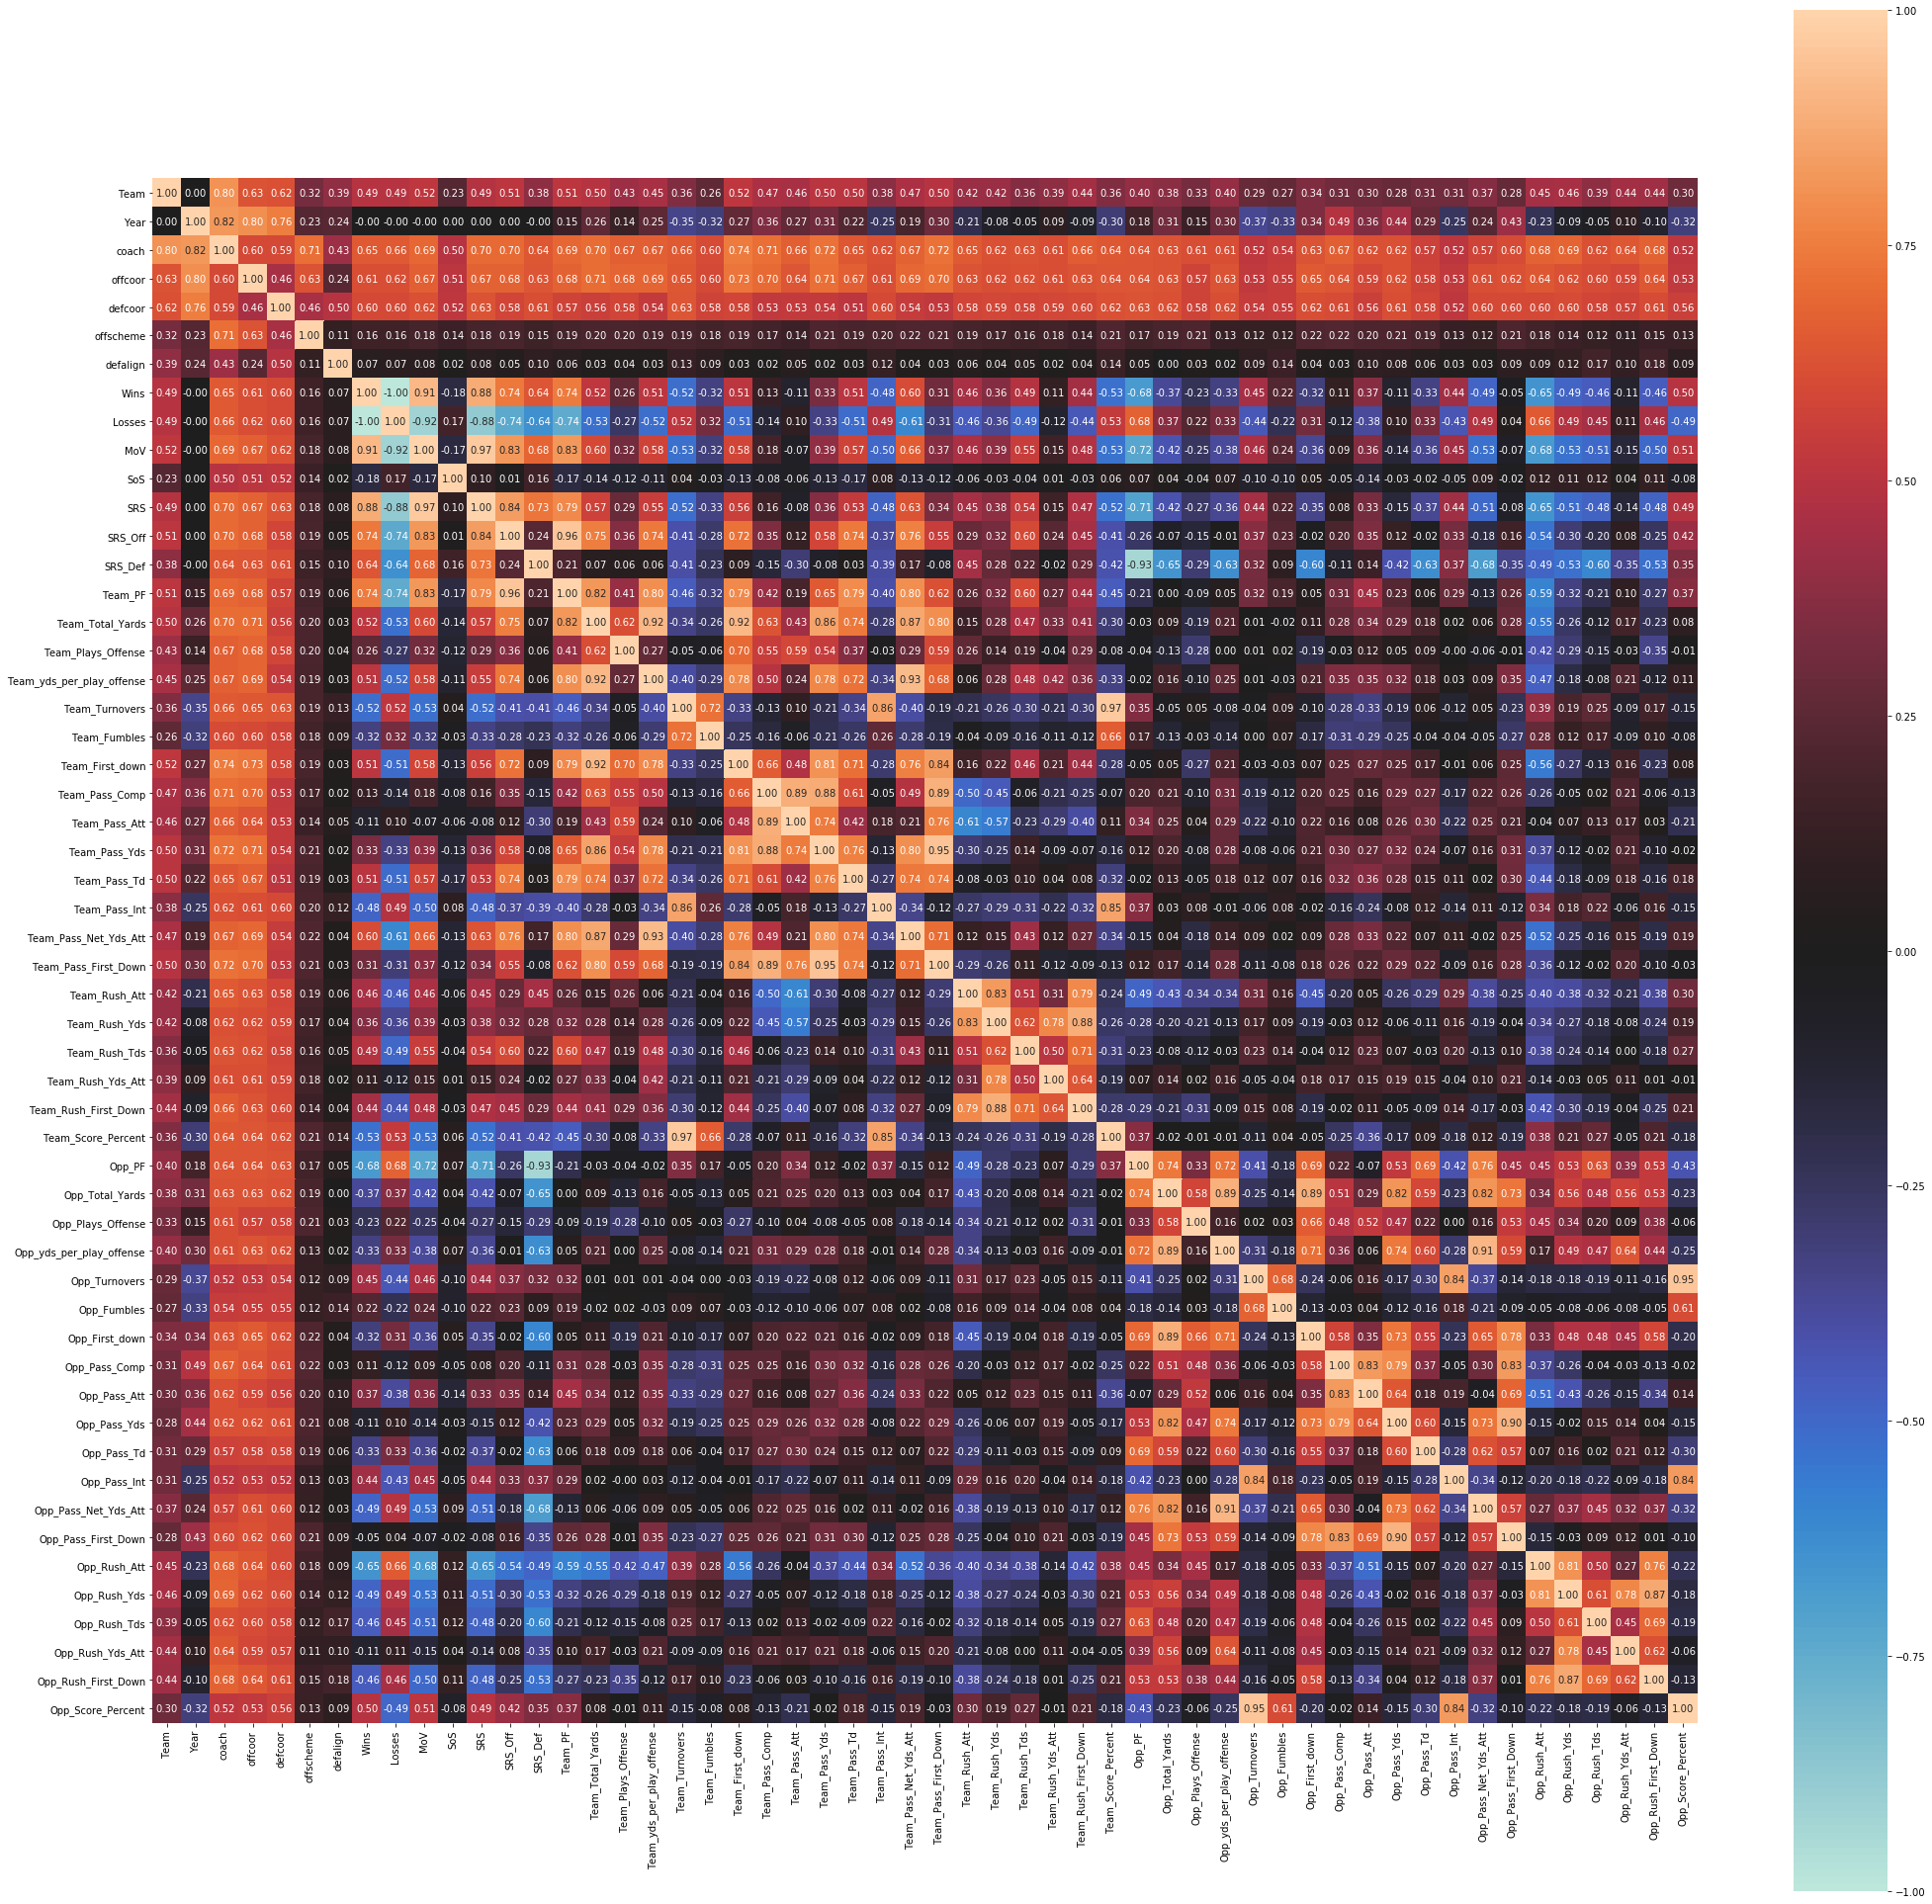

{'corr':                                Team      Year     coach   offcoor   defcoor  \
 Team                       1.000000  0.000000  0.804875  0.626320  0.623754   
 Year                       0.000000  1.000000  0.823169  0.799657  0.756913   
 coach                      0.804875  0.823169  1.000000  0.597024  0.594195   
 offcoor                    0.626320  0.799657  0.597024  1.000000  0.456095   
 defcoor                    0.623754  0.756913  0.594195  0.456095  1.000000   
 offscheme                  0.322169  0.227979  0.713992  0.626143  0.455902   
 defalign                   0.394538  0.239106  0.427923  0.238643  0.499625   
 Wins                       0.493223 -0.003375  0.654102  0.614084  0.596776   
 Losses                     0.493458 -0.003376  0.655927  0.616093  0.598358   
 MoV                        0.517736 -0.000218  0.689406  0.671607  0.621254   
 SoS                        0.227171  0.000223  0.498028  0.514981  0.519029   
 SRS                        0.49

In [31]:
from dython.nominal import associations
associations(teamyearsummary, figsize=(35,35))

### How similar is the correlation between the team year summary and team week breakdown?

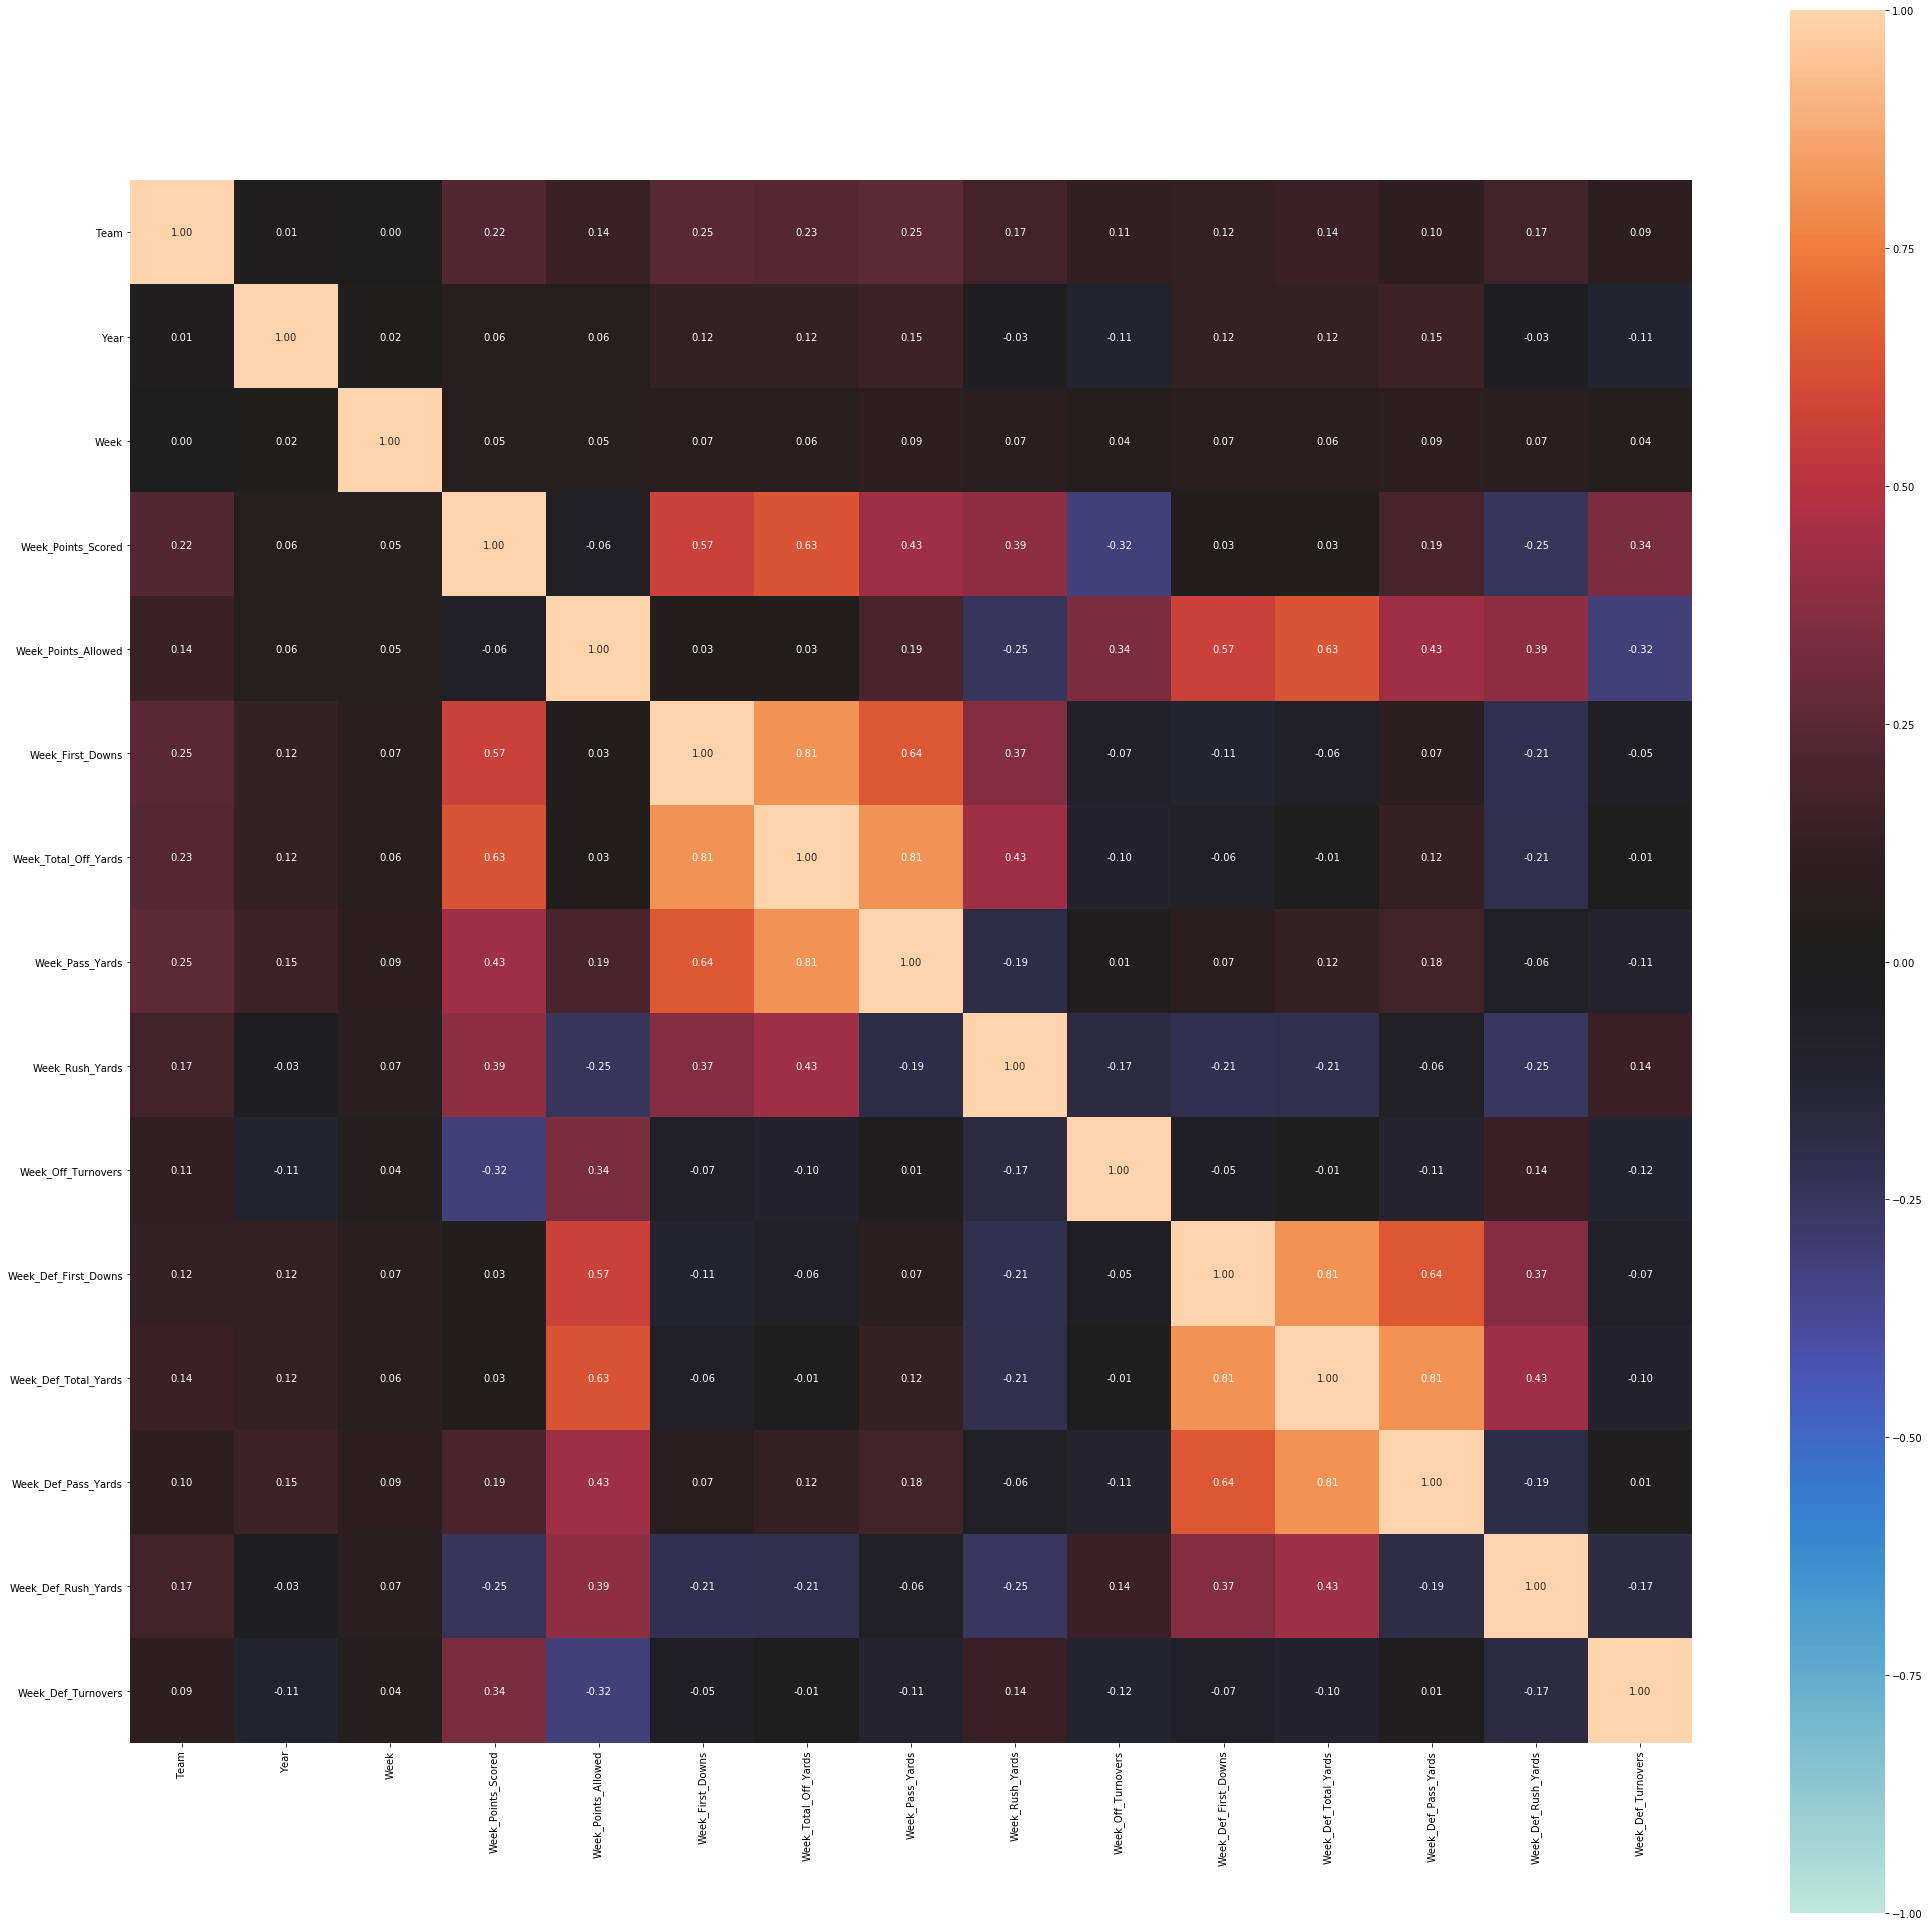

{'corr':                           Team      Year      Week  Week_Points_Scored  \
 Team                  1.000000  0.014263  0.000000            0.220480   
 Year                  0.014263  1.000000  0.022417            0.061025   
 Week                  0.000000  0.022417  1.000000            0.052099   
 Week_Points_Scored    0.220480  0.061025  0.052099            1.000000   
 Week_Points_Allowed   0.137198  0.061025  0.052099           -0.055698   
 Week_First_Downs      0.245147  0.124832  0.069251            0.565034   
 Week_Total_Off_Yards  0.226741  0.117775  0.063704            0.628679   
 Week_Pass_Yards       0.252159  0.148667  0.092213            0.429995   
 Week_Rush_Yards       0.168718 -0.031233  0.065031            0.386532   
 Week_Off_Turnovers    0.113402 -0.113578  0.040594           -0.316024   
 Week_Def_First_Downs  0.123424  0.124832  0.069251            0.034562   
 Week_Def_Total_Yards  0.142083  0.117915  0.063823            0.025585   
 Week_Def_Pass_Ya

In [32]:
associations(weeks, figsize=(35,35))

## What is the count of position types per round from 2002-2019

Text(0, 0.5, 'Position Pick Count')

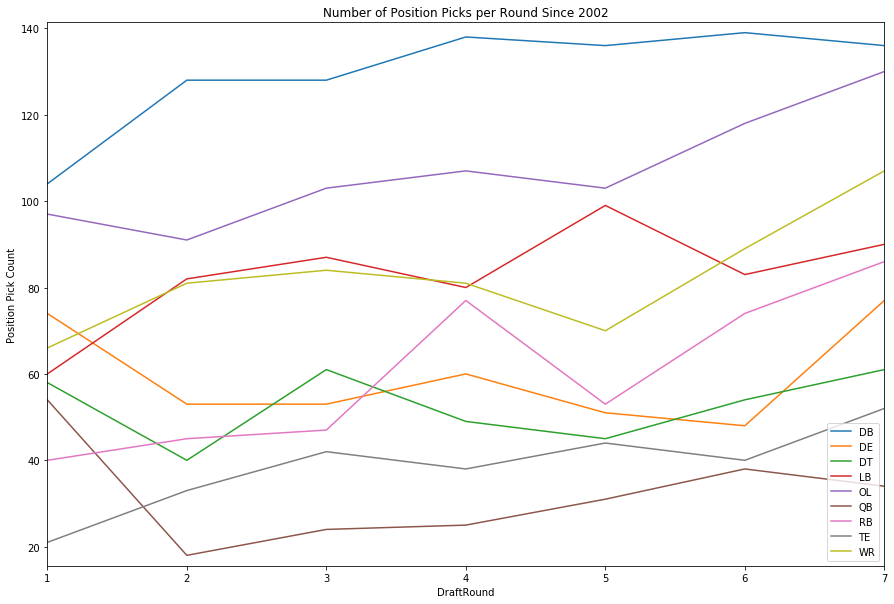

In [33]:
roundPosition = draft.groupby(['DraftRound', 'DraftPosition'])['DraftPlayer'].count().unstack().plot(figsize=(15,10))
plt.legend(loc='lower right')
plt.margins(0.02)
plt.title('Number of Position Picks per Round Since 2002')
plt.ylabel('Position Pick Count')

In [34]:
teamgroupeddraft = draft.groupby(['Team','DraftRound', 'DraftPosition'])['DraftPlayer'].count().unstack()

In [35]:
teamgroupeddraft

DraftPosition                         DB   DE   DT   LB   OL   QB   RB   TE  \
Team                     DraftRound                                           
Arizona Cardinals        1           4.0  1.0  3.0  1.0  3.0  3.0  1.0  NaN   
                         2           2.0  2.0  1.0  5.0  1.0  NaN  2.0  1.0   
                         3           5.0  3.0  1.0  3.0  1.0  1.0  1.0  2.0   
                         4           1.0  4.0  3.0  NaN  6.0  1.0  1.0  NaN   
                         5           2.0  4.0  NaN  2.0  4.0  1.0  4.0  NaN   
...                                  ...  ...  ...  ...  ...  ...  ...  ...   
Washington Football Team 3           4.0  NaN  NaN  NaN  6.0  NaN  1.0  2.0   
                         4           5.0  NaN  NaN  2.0  2.0  1.0  4.0  NaN   
                         5           2.0  1.0  3.0  5.0  2.0  NaN  1.0  3.0   
                         6           5.0  NaN  1.0  4.0  4.0  3.0  4.0  NaN   
                         7           8.0  4.0  1.0  2.0  6.0  1.0  5.0  2.0   

DraftPosition                         WR  
Team                     DraftRound       
Arizona Cardinals        1           3.0  
                         2           3.0  
                         3           4.0  
                         4           1.0  
                         5           3.0  
...                                  ...  
Washington Football Team 3           3.0  
                         4           1.0  
                         5           2.0  
                         6           4.0  
                         7           3.0  

[224 rows x 9 columns]

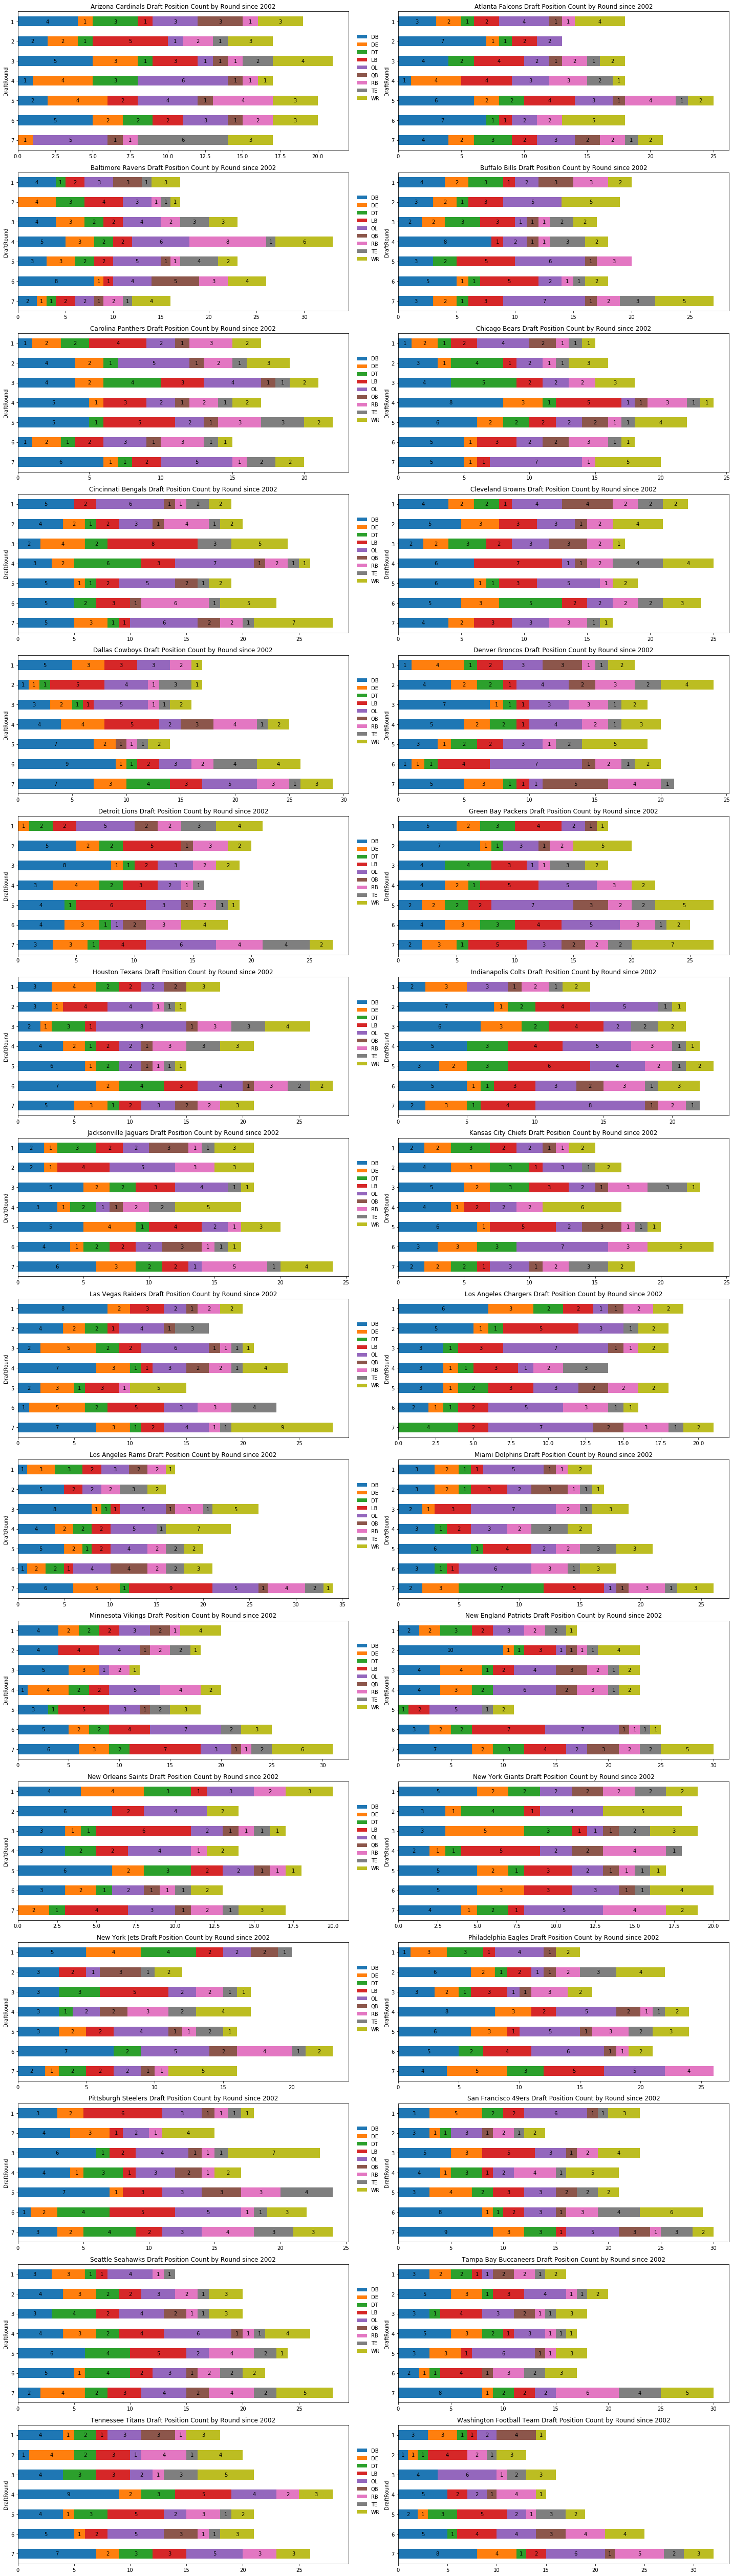

In [36]:
fig, axes = plt.subplots(16,2,figsize=(20,70))
for idx, team in enumerate(teamgroupeddraft.index.get_level_values(0).unique()):
        ax = teamgroupeddraft.loc[team].plot(kind='barh', stacked=True, figsize=(20,70), ax=axes.flatten()[idx])
        for p in ax.patches:
            left, bottom, width, height = p.get_bbox().bounds
            if width > 0:
                ax.annotate(str(int(width)), xy=(left+width/2, bottom+height/2), ha='center', va='center')
            else:
                pass
        ax.set_title(team + ' Draft Position Count by Round since 2002')
        ax.invert_yaxis()
        #plt.ylabel('Count')
        plt.tight_layout()
        if (idx+1)%2 == 0:
            ax.legend(frameon=False, bbox_to_anchor=(-.05,.85), loc='best', borderaxespad=0.)
        else:
            ax.legend('', frameon=False)

### How many players were selected in each position by year?

Text(0, 0.5, 'Position Pick Count')

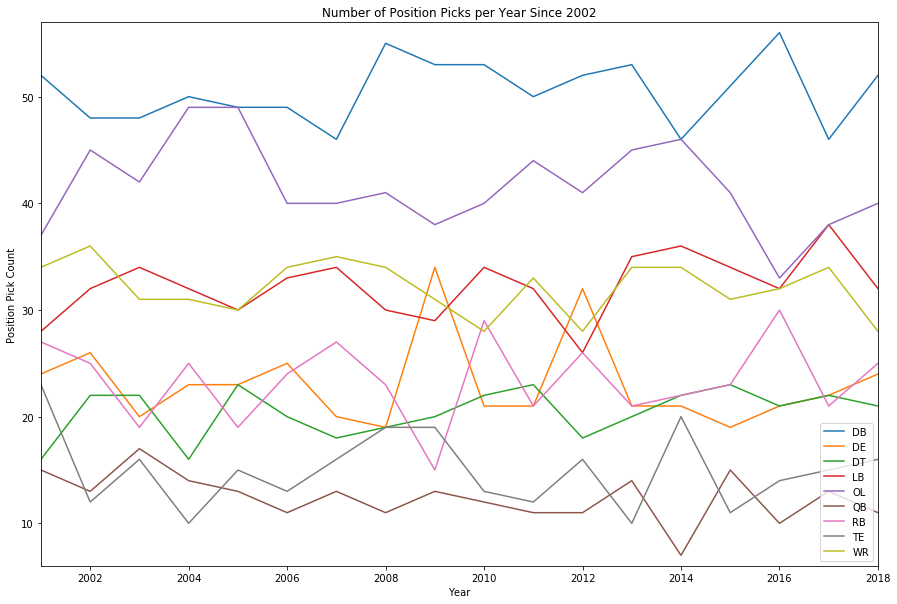

In [37]:
draft.groupby(['Year', 'DraftPosition'])['DraftPlayer'].count().unstack().plot(figsize=(15,10))
plt.legend(loc='lower right')
plt.margins(0.02)
plt.title('Number of Position Picks per Year Since 2002')
plt.ylabel('Position Pick Count')

What is the average number of years started by position, as well as the average games started by position by year

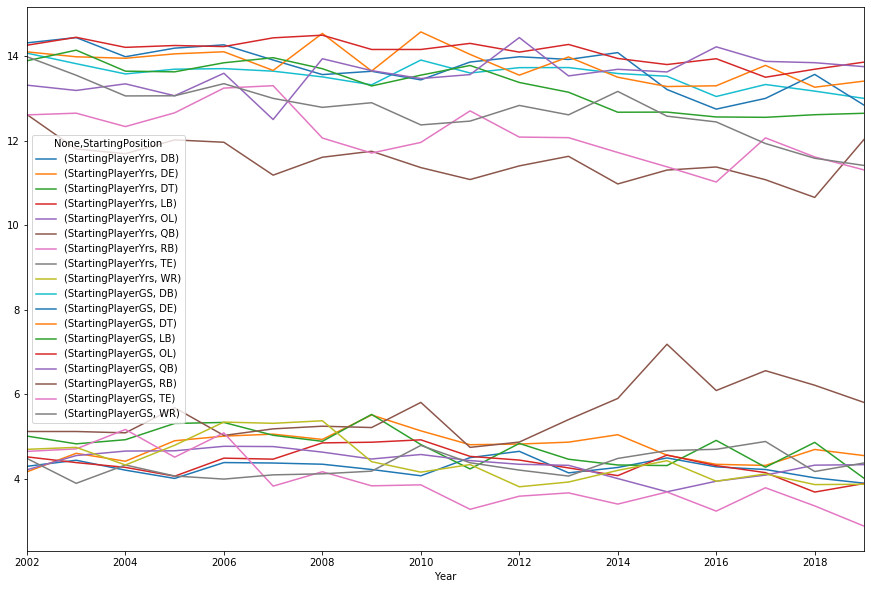

In [38]:
starters.groupby(['Year', 'StartingPosition'])['StartingPlayerYrs', 'StartingPlayerGS'].mean().unstack().plot(figsize=(15,10))

### Confirmation with this webpage that the groupby is what I wanted - https://www.pro-football-reference.com/draft/draft-totals.htm

In [39]:
draft.groupby(['Year', 'DraftPosition']).count()

Team  DraftRound  DraftPick  DraftPlayer  DraftSchool  \
Year DraftPosition                                                          
2001 DB               52          52         52           52           52   
     DE               24          24         24           24           24   
     DT               16          16         16           16           16   
     LB               28          28         28           28           28   
     OL               37          37         37           37           37   
...                  ...         ...        ...          ...          ...   
2018 OL               40          40         40           40           40   
     QB               11          11         11           11           11   
     RB               25          25         25           25           25   
     TE               16          16         16           16           16   
     WR               28          28         28           28           28   

                    DraftTeamSelection  
Year DraftPosition                      
2001 DB                             52  
     DE                             24  
     DT                             16  
     LB                             28  
     OL                             37  
...                                ...  
2018 OL                             40  
     QB                             11  
     RB                             25  
     TE                             16  
     WR                             28  

[162 rows x 6 columns]

### Grouping team, year, and Starting Position and grouping on avg. starting years and avg. starting games started

Unstacking the multiindex and then concatenating on the teamyearsummary dataframe.  

Grouping Draft position by team and year on the team selection order

Doing all of this to see if there are any larger correlations between the teamyearsummary, starter information, and then how the draft is picked by team by year

In [40]:
starters.columns

Index(['Team', 'Year', 'StartingPlayer', 'StartingPlayerAge',
       'StartingPosition', 'StartingPlayerYrs', 'StartingPlayerGS',
       'YrsTeamStarter', 'AV'],
      dtype='object')

In [51]:
starters.isnull().sum()

Team                    0
Year                    0
StartingPlayer          0
StartingPlayerAge       0
StartingPosition        0
StartingPlayerYrs       0
StartingPlayerGS        0
YrsTeamStarter          0
AV                   3623
dtype: int64

In [41]:
startergroup = starters.groupby(['Team', 'Year', 'StartingPosition'])['StartingPlayerYrs', 'StartingPlayerGS', 'AV'].mean().unstack()

In [42]:
startergroup = startergroup.reset_index()

### Flattening multiindex to concat dataframes

In [43]:
startergroup.columns = startergroup.columns.map('{0[0]}{0[1]}'.format)

In [44]:
startergroup

Team  Year  StartingPlayerYrsDB  StartingPlayerYrsDE  \
0           Arizona Cardinals  2002                 3.50                  1.0   
1           Arizona Cardinals  2003                 2.75                  0.5   
2           Arizona Cardinals  2004                 3.25                  6.0   
3           Arizona Cardinals  2005                 7.00                  7.0   
4           Arizona Cardinals  2006                 4.75                  8.0   
..                        ...   ...                  ...                  ...   
571  Washington Football Team  2015                 5.25                  7.5   
572  Washington Football Team  2016                 5.00                  7.0   
573  Washington Football Team  2017                 3.50                  4.0   
574  Washington Football Team  2018                 4.00                  1.5   
575  Washington Football Team  2019                 4.25                  2.5   

     StartingPlayerYrsDT  StartingPlayerYrsLB  StartingPlayerYrsOL  \
0                    4.0             5.333333                  3.4   
1                    3.0             3.666667                  4.4   
2                    2.5             5.000000                  2.8   
3                    2.5             4.333333                  2.8   
4                    4.0             3.333333                  2.6   
..                   ...                  ...                  ...   
571                  6.0             3.250000                  2.0   
572                  7.0             3.500000                  3.4   
573                  8.0             3.750000                  3.8   
574                  0.0             5.750000                  4.8   
575                  1.0             3.500000                  5.4   

     StartingPlayerYrsQB  StartingPlayerYrsRB  StartingPlayerYrsTE  ...  \
0                    5.0                  2.0                  5.0  ...   
1                   11.0                  3.0                  6.0  ...   
2                    2.0                 14.0                  7.0  ...   
3                    7.0                  4.0                  0.5  ...   
4                    0.0                  7.0                  5.0  ...   
..                   ...                  ...                  ...  ...   
571                  3.0                  3.0                  2.5  ...   
572                  4.0                  0.0                  6.5  ...   
573                  5.0                  0.0                  8.5  ...   
574                 13.0                 11.0                  5.0  ...   
575                  7.0                 12.0                  2.0  ...   

     StartingPlayerGSWR  AVDB  AVDE  AVDT      AVLB  AVOL  AVQB  AVRB  AVTE  \
0             10.000000   NaN   NaN   NaN       NaN   NaN   NaN   NaN   NaN   
1             13.000000   NaN   NaN   NaN       NaN   NaN   NaN   NaN   NaN   
2             12.000000   NaN   NaN   NaN       NaN   NaN   NaN   NaN   NaN   
3             15.000000   NaN   NaN   NaN       NaN   NaN   NaN   NaN   NaN   
4             12.333333  5.25   5.5   5.5  5.666667   6.4   8.0   8.0   0.0   
..                  ...   ...   ...   ...       ...   ...   ...   ...   ...   
571           12.500000  5.00   6.5   7.0  6.250000   8.2  12.0   4.0   4.5   
572           15.500000  4.00   5.5   6.0  8.000000   9.0  15.0   5.0   5.5   
573           10.000000  5.25   5.0   6.0  7.250000   6.2  12.0   5.0   3.0   
574            8.666667  5.25   6.5   8.0  8.250000   5.2   6.0   7.0   4.0   
575            9.333333   NaN   NaN   NaN       NaN   NaN   NaN   NaN   NaN   

         AVWR  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4    8.333333  
..        ...  
571  5.000000  
572  9.000000  
573  5.000000  
574  3.000000  
575       NaN  

[576 rows x 29 columns]

## Target Dataframes
Target features- Draft Pick Position/ Draft Team Selection

1. teamyearsummary + starters + draft 
#removeAV
AVcols = ['AVDB', 'AVDE', 'AVDT', 'AVLB', 'AVOL', 'AVQB', 'AVRB', 'AVTE', 'AVWR']
teamstarterdraft
2. teamyearsummary + startersAV + draft(2006-2018 limitation of AV data)
teamstarterdraft

3. week summary + starters + draft
4. week summary + startersAV + draft(2006-2018 limitation of AV data)


Models to try
(perform lasso Regression to see if coach/def align etc are important features)

1. Regression
    1. Ridge
    2. Random Forest Regression
    3. XGBoost
2. Classification
    1. Random Forest
    2. Gradient Boosting
    3. XGBoost



In [45]:
draftpositionselection = draft[['Team', 'Year', 'DraftPosition','DraftTeamSelection']]

### teamyearsummary + starters + draft

In [54]:
teamyearstarter = pd.merge(teamyearsummary, startergroup, how='inner', on=['Team', 'Year'])
teamstarterdraft = pd.merge(teamyearstarter, draftpositionselection, how='inner', on=['Team', 'Year'])
AVcols =  ['AVDB', 'AVDE', 'AVDT', 'AVLB', 'AVOL', 'AVQB', 'AVRB', 'AVTE', 'AVWR']
teamstarterdraft.drop(columns=AVcols, inplace=True)
teamstarterdraft.to_csv('teamstarterdraft.csv', index=False)

### teamyearsummary + startersAV + draft (2006-2018 limitation of AV data)

In [55]:
teamyearstarterAV = pd.merge(teamyearsummary, startergroup, how='inner', on=['Team', 'Year'])
teamstarterdraftAV = pd.merge(teamyearstarter, draftpositionselection, how='inner', on=['Team', 'Year'])
#Remove data from years that do not have AV
teamstarterdraftAV.dropna(inplace=True)
teamstarterdraftAV.to_csv('teamstarterdraftAV.csv', index=False)

### week + starters + draft

In [56]:
weekstarter = pd.merge(weeks, startergroup, how='inner', on=['Team', 'Year'])
weekstarterdraft = pd.merge(weekstarter, draftpositionselection, how='inner', on=['Team', 'Year'])
weekstarterdraft.drop(columns=AVcols, inplace=True)
weekstarterdraft.to_csv('weekstarterdraft.csv', index=False)

### week + startersAV + draft(2006-2018 limitation of AV data)

In [57]:
weekstarterAV = pd.merge(weeks, startergroup, how='inner', on=['Team', 'Year'])
weekstarterdraftAV = pd.merge(weekstarterAV, draftpositionselection, how='inner', on=['Team', 'Year'])
#Remove data from years that do not have AV
weekstarterdraftAV.dropna(inplace=True)
weekstarterdraftAV.to_csv('weekstarterdraftAV.csv', index=False)

## Are there any glaring correlations with our target features?

In [ ]:
from dython.nominal import compute_associations

In [ ]:
teamstarterdraftcorrAV = compute_associations(teamstarterdraftAV, clustering=True)

In [ ]:
teamstarterdraftcorr

In [ ]:
teamstarterdraftcorrAV[['DraftTeamSelection', 'DraftPosition']].sort_values('DraftTeamSelection', ascending=False)

In [ ]:
teamstarterdraftcorrAV[['DraftTeamSelection', 'DraftPosition']].sort_values('DraftPosition', ascending=False)

In [ ]:
teamstarterdraft.columns